# Sequences

__Sequences__ contain sequential information (temporal autocorrelation structure) that can be leveraged to predict future or categorize the past.

Main goals - Predict the future (forecasting); assign a category (classification)

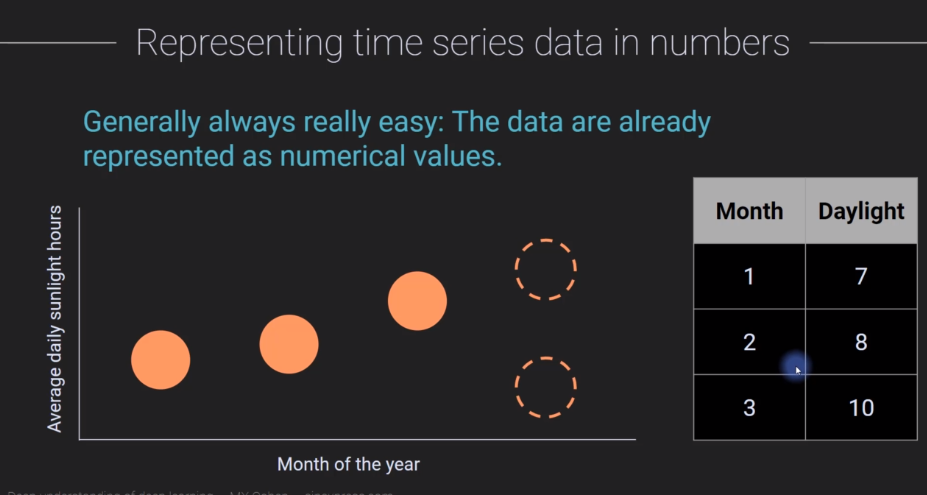

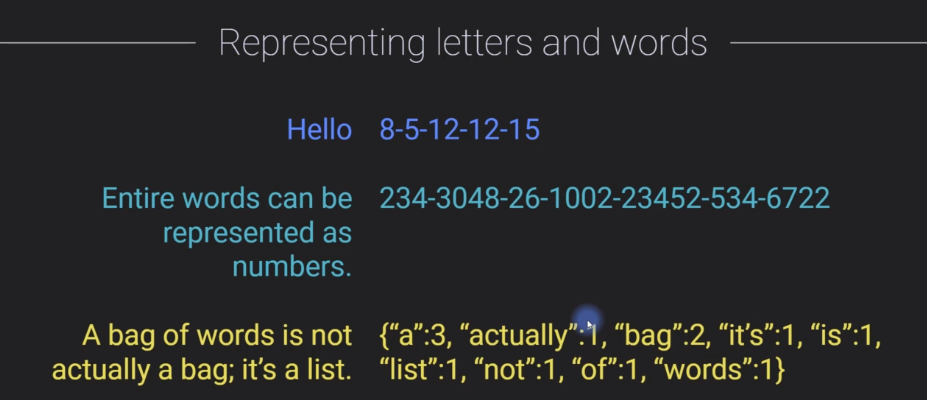

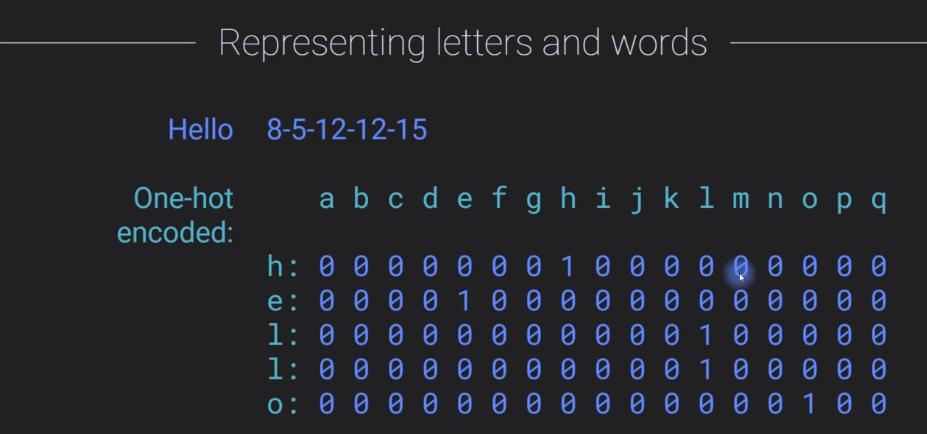

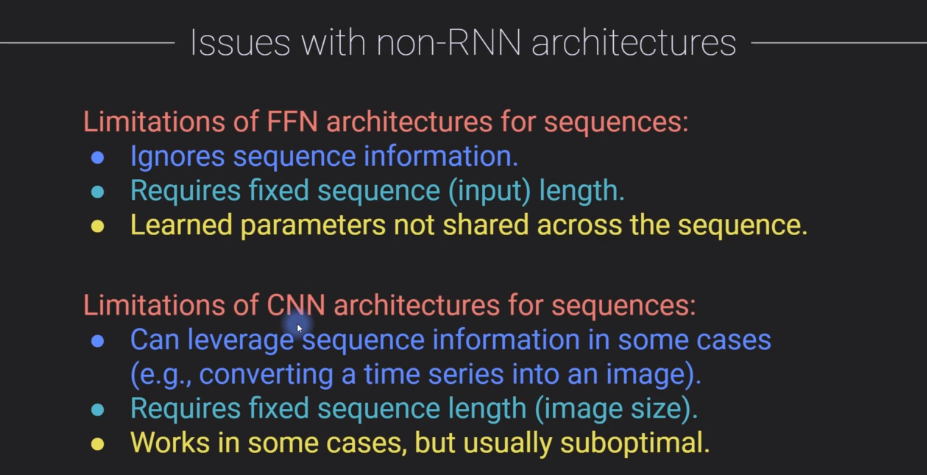

# How RNNs work

$W_{ih}$ - weights from input to hidden layers  
$W_{ho}$ - weights from hidden to op layers
$W_{hh}$ - weights from a hidden layer to itself. takes hidden layer activation and transforms it back to itself. This happens over time, i.e. over a sequence

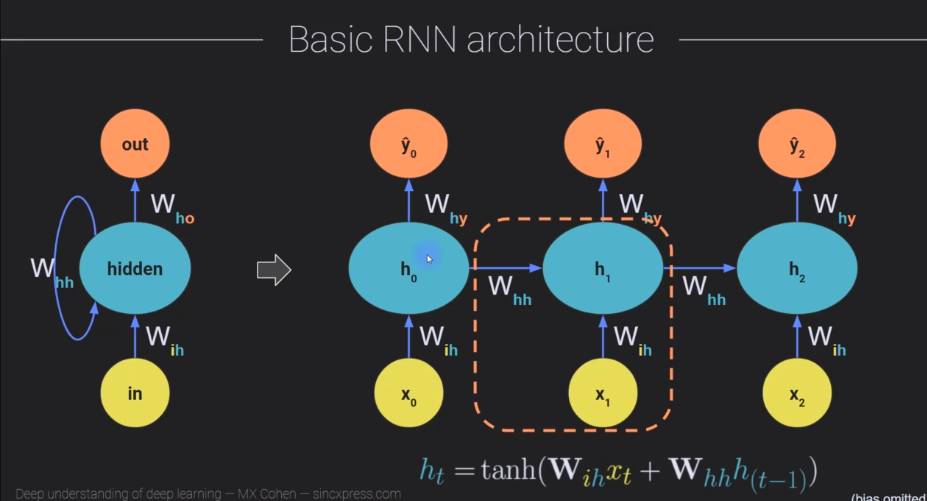

Ip and op are changing at each step, but $W_{ih}$, $W_{hy}$, $W_{hh}$ are same across all steps.

Above eq can also be written as $h_t = \tanh(W_h[x_t;h_{(t-1]})$

Number of ip or op units is a design choice.

Below could be used for classification:

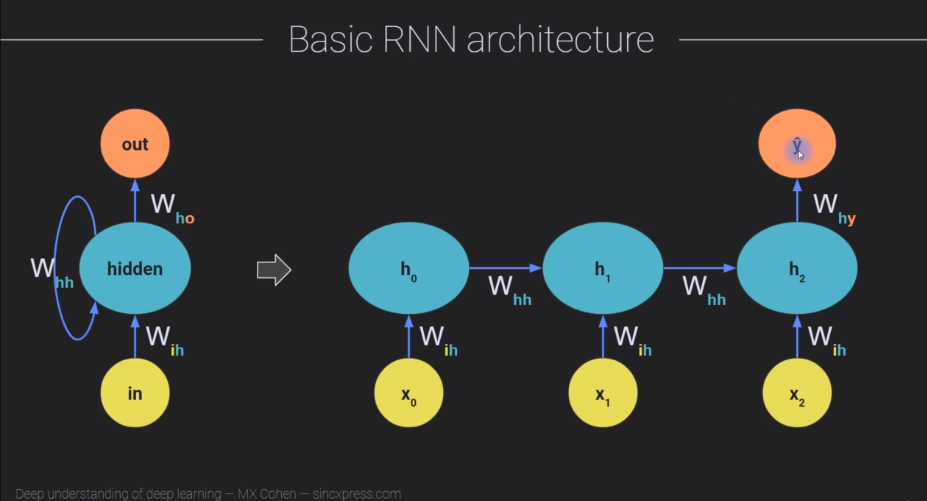

Below could be used as Generative model:

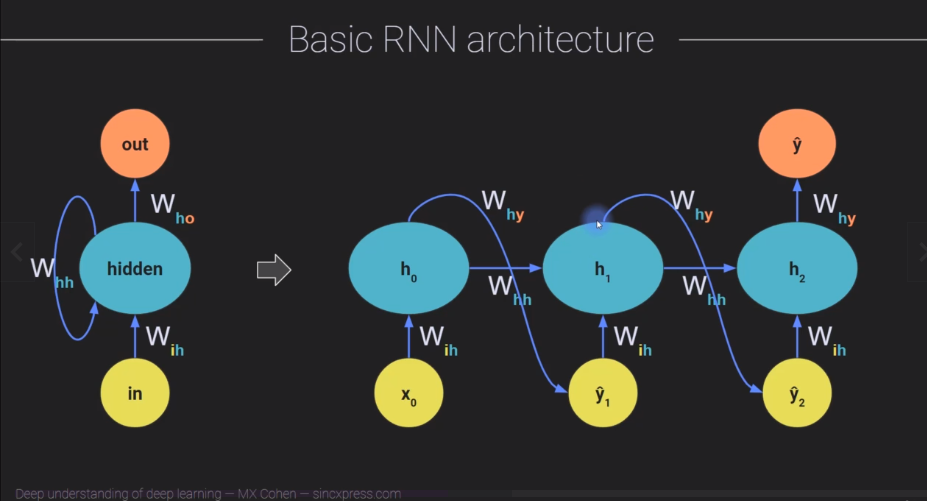

We can also have multiple hidden layers:

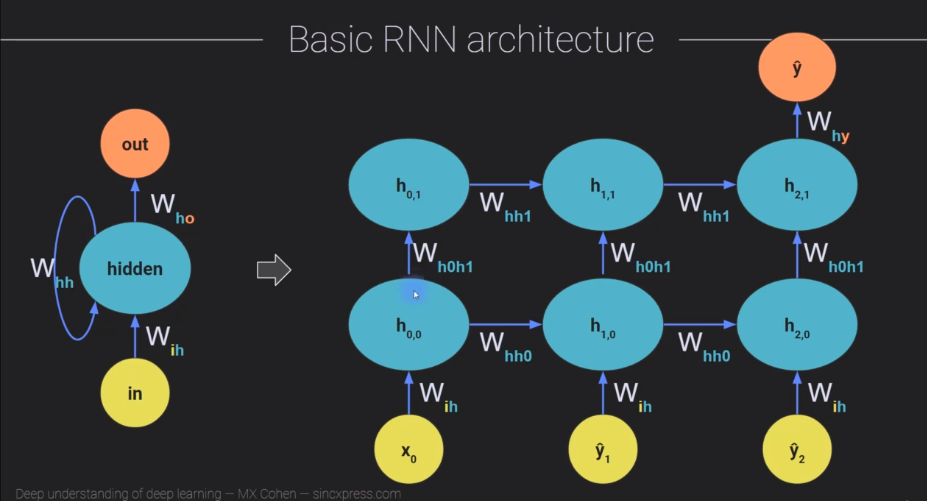

### Backpropogation "through time"

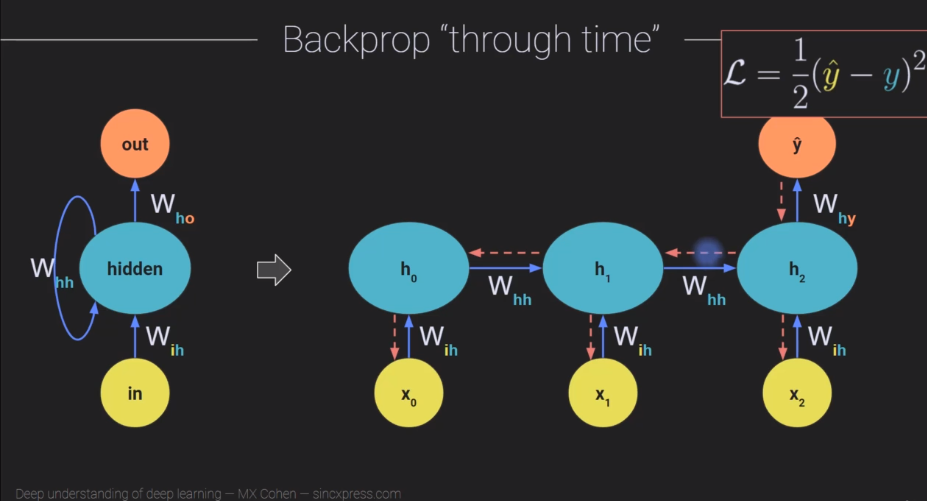

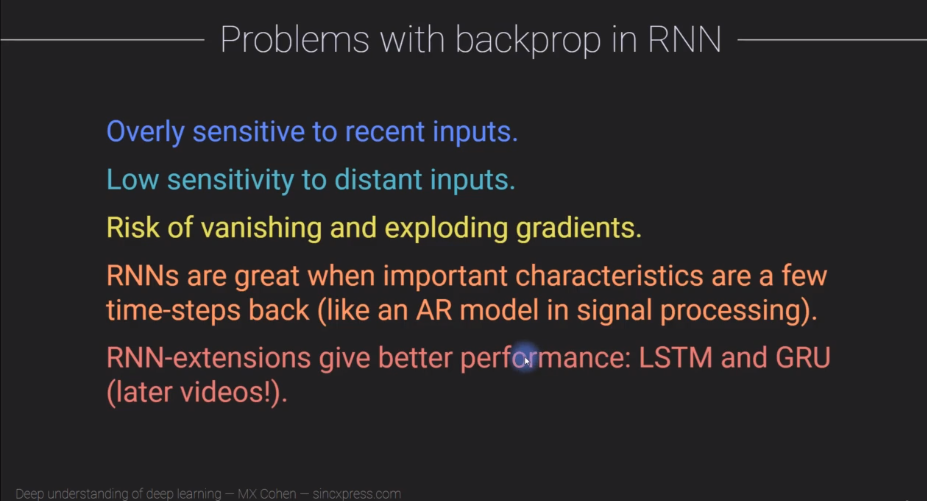

# RNN class in Pytorch

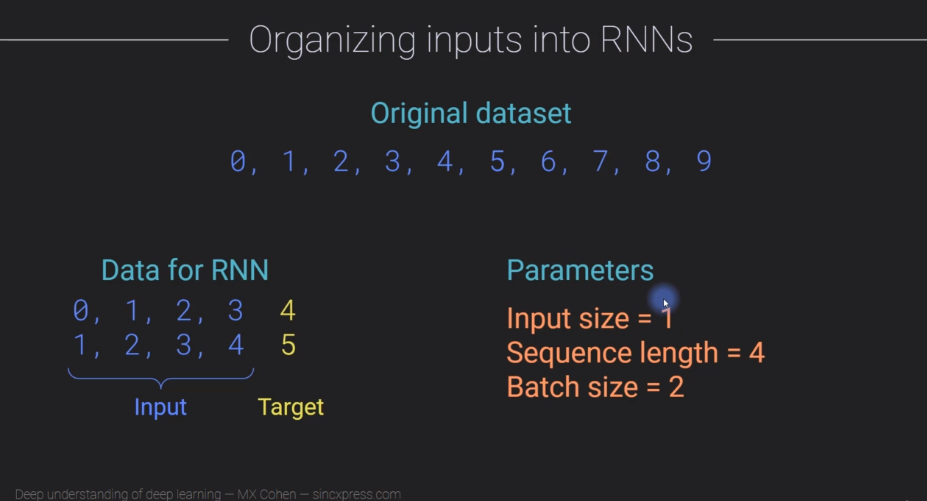

It is good practice to have overlapping snippets in general so that the model gets more data for training.

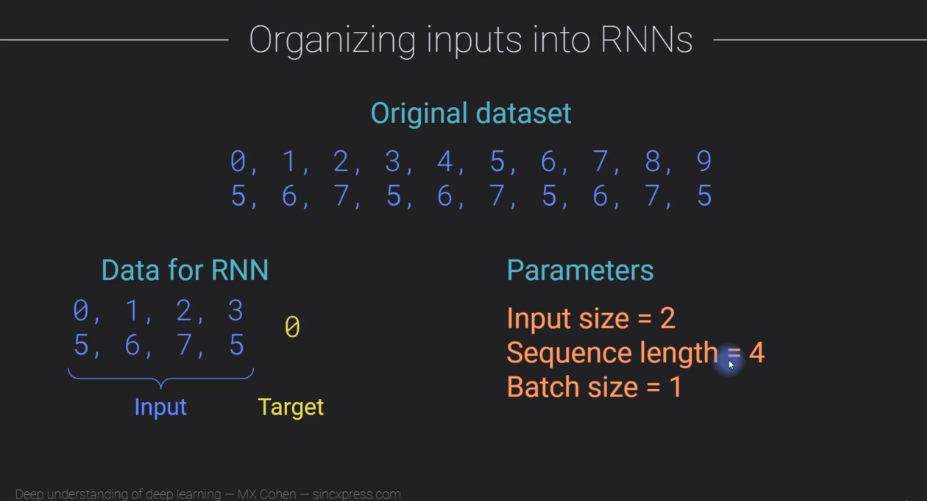

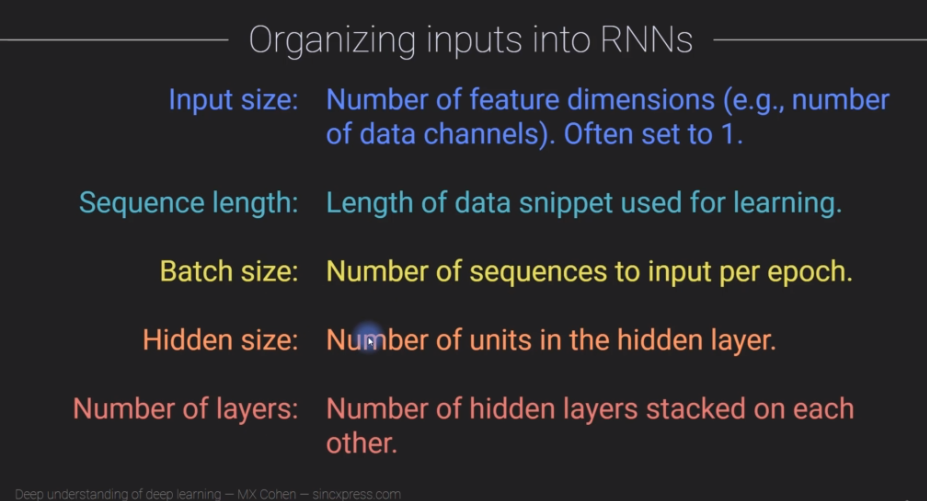

In [1]:
import torch
import torch.nn as nn
import numpy as np

In [4]:
# setting layer parameters

ip_size = 9 # no. of features to extract (eg. no. of data channels)
hidden_size = 16 # number of units in hidden state
nLayers = 1 # bo. of vertical stacks of hidden layers (note: only the final layer gives an output)
actfn = 'tanh'
bias = True

# creating RNN instance
rnn = nn.RNN(ip_size, hidden_size, nLayers, nonlinearity=actfn,bias=bias)
print(rnn)

RNN(9, 16)


In [3]:
??nn.RNN

In [5]:
# RNN parameters

seqlength = 5
batchsize = 2

# creating  new data
X = torch.randn(seqlength,batchsize,ip_size)

# creating a hidden layer
hidden = torch.zeros(nLayers, batchsize, hidden_size)

# passing through RNN (typical ip to RNN is given as follows)
y, h = rnn(X, hidden)
print(X.shape)
print(h.shape)
print(y.shape)

torch.Size([5, 2, 9])
torch.Size([1, 2, 16])
torch.Size([5, 2, 16])


In [9]:
# default hidden state is all 0s if nothing specified
y, h1 = rnn(X, hidden)
print(h1)

y, h2 = rnn(X)
print('\n\n',h2)

h1 == h2

tensor([[[ 0.0339,  0.5445, -0.0357, -0.3716,  0.7076,  0.3492,  0.6295,
          -0.2245, -0.0623,  0.0657,  0.4843, -0.3539,  0.0840, -0.2163,
           0.2944,  0.1948],
         [-0.4644,  0.0705,  0.0686,  0.3386,  0.5945, -0.3637,  0.5006,
           0.1756, -0.5528, -0.2564,  0.5402, -0.1572, -0.1994, -0.1052,
           0.1509,  0.4024]]], grad_fn=<StackBackward0>)


 tensor([[[ 0.0339,  0.5445, -0.0357, -0.3716,  0.7076,  0.3492,  0.6295,
          -0.2245, -0.0623,  0.0657,  0.4843, -0.3539,  0.0840, -0.2163,
           0.2944,  0.1948],
         [-0.4644,  0.0705,  0.0686,  0.3386,  0.5945, -0.3637,  0.5006,
           0.1756, -0.5528, -0.2564,  0.5402, -0.1572, -0.1994, -0.1052,
           0.1509,  0.4024]]], grad_fn=<StackBackward0>)


tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True]]])

In [10]:
# checking the learned parameters and their sizes
for p in rnn.named_parameters():
    if 'weight' in p[0]:
        print(f'{p[0]} has size {list(p[1].shape)}')

weight_ih_l0 has size [16, 9]
weight_hh_l0 has size [16, 16]


## Creating a DL model class

In [11]:
class RNNNet(nn.Module):
    def __init__(self, ip_size, nHidden, nLayers):
        super().__init__()
        
        # store parameters
        self.ip_size = ip_size
        self.nHidden = nHidden
        self.nLayers = nLayers
        
        # RNN layer
        self.rnn = nn.RNN(ip_size, nHidden, nLayers)
        
        # linear layer for op
        self.op = nn.Linear(nHidden, 1)
        
    def forward(self, x):
        print(f'Input:{list(x.shape)}')
        
        # initialize hidden state for first input
        hidden = torch.zeros(self.nLayers, batchsize, self.nHidden)
        print(f'Hidden:{list(hidden.shape)}')
        
        # run through RNN
        y, hidden = self.rnn(x, hidden)
        print(f'RNN-out:{list(y.shape)}')
        print(f'RNN-hidden:{list(hidden.shape)}')
        
        # run RNN op through op layer
        o = self.op(y)
        print(f'Output:{list(o.shape)}')
        
        return o, hidden

In [12]:
# creating instance of RNN net

net = RNNNet(ip_size, hidden_size, nLayers)
print(net, ' ')

for p in net.named_parameters():
    print(f'{p[0]} has size {list(p[1].shape)}')

RNNNet(
  (rnn): RNN(9, 16)
  (op): Linear(in_features=16, out_features=1, bias=True)
)  
rnn.weight_ih_l0 has size [16, 9]
rnn.weight_hh_l0 has size [16, 16]
rnn.bias_ih_l0 has size [16]
rnn.bias_hh_l0 has size [16]
op.weight has size [1, 16]
op.bias has size [1]


In [14]:
# testing model with some data

X = torch.rand(seqlength, batchsize, ip_size)
y = torch.rand(seqlength, batchsize, 1)
yH, h = net(X)

lossfn = nn.MSELoss()
lossfn(yH, y)

Input:[5, 2, 9]
Hidden:[1, 2, 16]
RNN-out:[5, 2, 16]
RNN-hidden:[1, 2, 16]
Output:[5, 2, 1]


tensor(0.2028, grad_fn=<MseLossBackward0>)

# Predicting Alternating Sequences

In [16]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

import warnings; warnings.filterwarnings('ignore')
# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

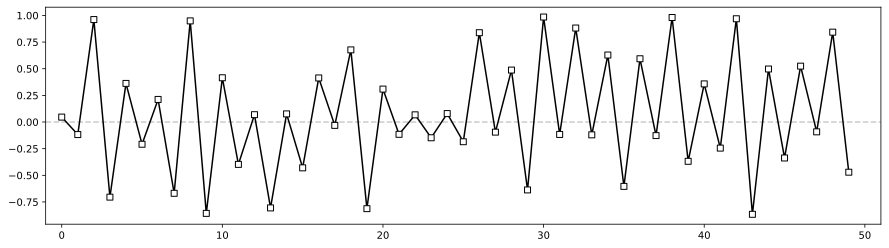

In [17]:
# import the data
N = 50

data = torch.zeros(N)

for i in range(N):
    data[i] = torch.rand(1) * (-1)**i

plt.figure(figsize=(15,4))
plt.plot([-1,N+1],[0,0],'--',color=[.8,.8,.8])
plt.plot(data,'ks-',markerfacecolor='w')
plt.xlim([-1,N+1])
plt.show()

Above sequence has only one data stream/channel. Hence, input size will be 1

In [20]:
class RNNNet(nn.Module):
    def __init__(self, ip_size, nHidden, nLayers):
        super().__init__()
        
        # store parameters
        self.ip_size = ip_size
        self.nHidden = nHidden
        self.nLayers = nLayers
        
        # RNN layer
        self.rnn = nn.RNN(ip_size, nHidden, nLayers)
        
        # linear layer for op
        self.op = nn.Linear(nHidden, 1)
        
    def forward(self, x):
            
        # run through RNN
        y, hidden = self.rnn(x) # hidden will be 0 by default
        
        # run RNN op through op layer
        o = self.op(y)
        
        return o, hidden

In [21]:
# network  parameters

ip_size = 1 # channels of data
nHidden = 5 # no. of units in hidden layers
nlayers = 1 # no. of hidden layers (stacks of hidden layers)
seq_length = 9 # no. of points of ip taken at once
batchsize = 1 

In [25]:
net = RNNNet(ip_size, nHidden, nLayers)

X = torch.rand(seq_length,batchsize,ip_size)

y, h = net(X)
print(X.shape)
print(y.shape) # we need only one output per sequence, so we extract the final element of op sequence
print(h.shape)

torch.Size([9, 1, 1])
torch.Size([9, 1, 1])
torch.Size([1, 1, 5])


In [26]:
# testing the model with some data
some_data = data[:seq_length].view(seq_length,1,1)
y = net(some_data)

# extracting final value from predicted sequence (first element of tuple op from net)
final_val = y[0][-1]

lossfn = nn.MSELoss()
lossfn(final_val, data[seq_length].view(1,1))

tensor(1.0310, grad_fn=<MseLossBackward0>)

In [30]:
print(y[0][-1])

tensor([[0.1582]], grad_fn=<SelectBackward0>)


### training model

In [38]:
nEp = 30

# new instance of model and optimizer
net = RNNNet(ip_size, nHidden, nLayers)
optim = torch.optim.SGD(net.parameters(),lr=.001)

# initializing losses
losses = np.zeros(nEp)
signacc = np.zeros(nEp)

# loop over epochs
for i in range(nEp):
    seglosses = []
    segacc = []
    hidden_state = torch.zeros(nLayers,batchsize,nHidden) # reset hidden state every epoch
    
    for timei in range(N-seq_length):
        
        # snippet of data
        X = data[timei:timei+seq_length].view(seq_length,1,1) # say elements of indices t to t+9-1
        y = data[timei+seq_length].view(1,1) # (9-1)th ele is the label
        
        # forward pass
        yH, hidden_state = net(X)
        final_val = yH[-1]
        loss = lossfn(final_val, y)
        
        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        # losses from this segment
        seglosses.append(loss.item())
        
        
        # getting sign accuracy
        truesign = np.sign(torch.squeeze(y)).numpy()
        predsign = np.sign(torch.squeeze(final_val).detach().numpy())
        acc = 100*(truesign==predsign)
        segacc.append(acc)
    
    # avg epoch losses
    losses[i] = np.mean(seglosses)
    signacc[i] = np.mean(segacc)
    
    sys.stdout.write('\r' + f'Finished epoch : {i+1}/{nEp}')

Finished epoch : 30/30

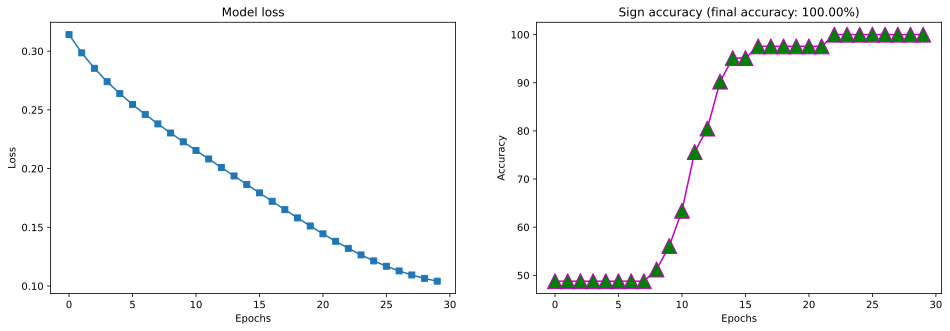

In [39]:
## let's see how the model did!

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(signacc,'m^-',markerfacecolor='g',markersize=15)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Sign accuracy (final accuracy: %.2f%%)'%signacc[-1])

plt.show()

### Testing the network on same data

In [40]:
# initialize hidden state

h = np.zeros((N,nHidden))

# initialize predicted val
yH = np.zeros(N)

# looping over time segments
for timei in range(N-seq_length):
    X = data[timei:timei+seq_length].view(seq_length,1,1)
    
    yy, hh = net(X)
    yH[timei+seq_length] = yy[-1]
    h[timei+seq_length] = hh.detach()
    
truesign = np.sign(data.numpy())
predsign = np.sign(yH)
signacc = 100*np.mean(truesign[seq_length:]==predsign[seq_length:])

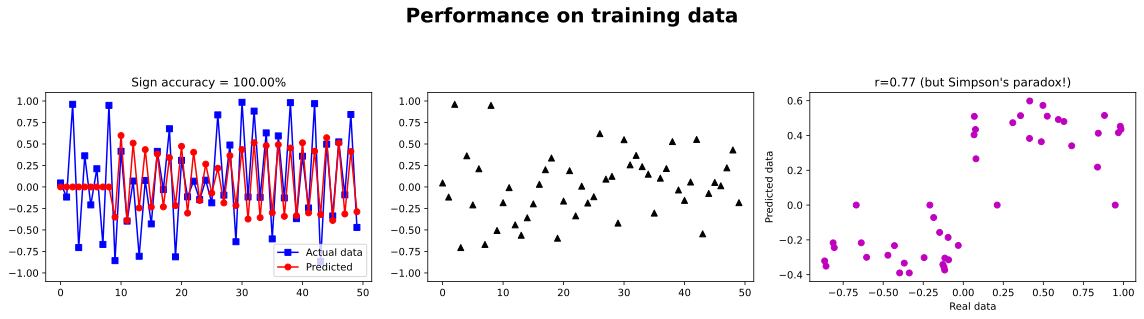

In [42]:
## plot!
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yH,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].set_title('Sign accuracy = %.2f%%' %signacc)
ax[0].legend()

ax[1].plot(data-yH,'k^')
ax[1].set_ylim([-1.1,1.1])

ax[2].plot(data[seqlength:],yH[seqlength:],'mo')
ax[2].set_xlabel('Real data')
ax[2].set_ylabel('Predicted data')
r = np.corrcoef(data[seqlength:],yH[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f} (but Simpson's paradox!)")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

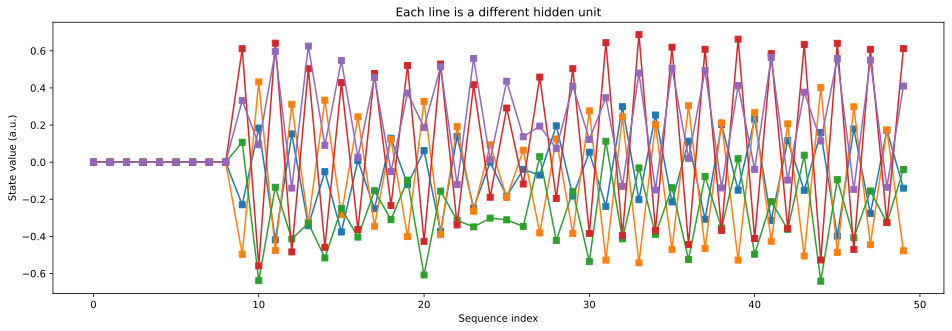

In [43]:
# show the hidden "states" (units activations)
plt.figure(figsize=(16,5))

plt.plot(h,'s-')
plt.xlabel('Sequence index')
plt.ylabel('State value (a.u.)')
plt.title('Each line is a different hidden unit')
plt.show()

### Testing model with NEW data and FLIPPED signs

In [44]:
newData = torch.zeros(N)
for i in range(N):
    newData[i] = torch.rand(1)*(-1)**(i+1)

In [45]:
# initialize hidden state

h = np.zeros((N,nHidden))

# initialize predicted val
yH = np.zeros(N)

# looping over time segments
for timei in range(N-seq_length):
    X = newData[timei:timei+seq_length].view(seq_length,1,1)
    
    yy, hh = net(X)
    yH[timei+seq_length] = yy[-1]
    h[timei+seq_length] = hh.detach()
    
truesign = np.sign(newData.numpy())
predsign = np.sign(yH)
signacc = 100*np.mean(truesign[seq_length:]==predsign[seq_length:])

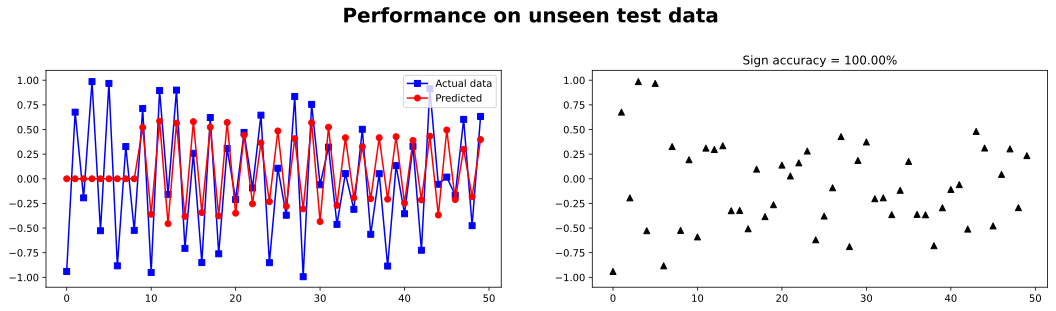

In [47]:
fig,ax = plt.subplots(1,2,figsize=(18,4))
ax[0].plot(newData,'bs-',label='Actual data')
ax[0].plot(yH,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newData-yH,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Sign accuracy = %.2f%%' %signacc)

plt.suptitle('Performance on unseen test data',fontweight='bold',fontsize=20,y=1.1)
plt.show()

# RNN Embeddings and Hidden states

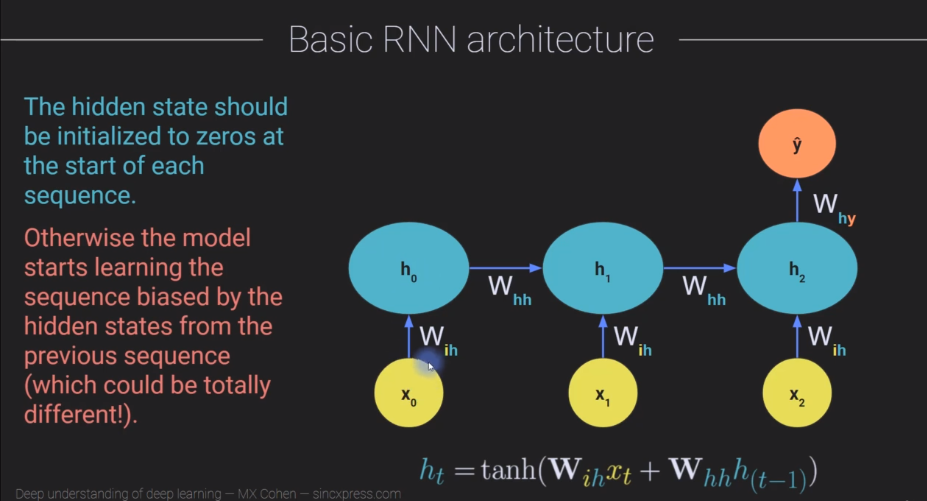

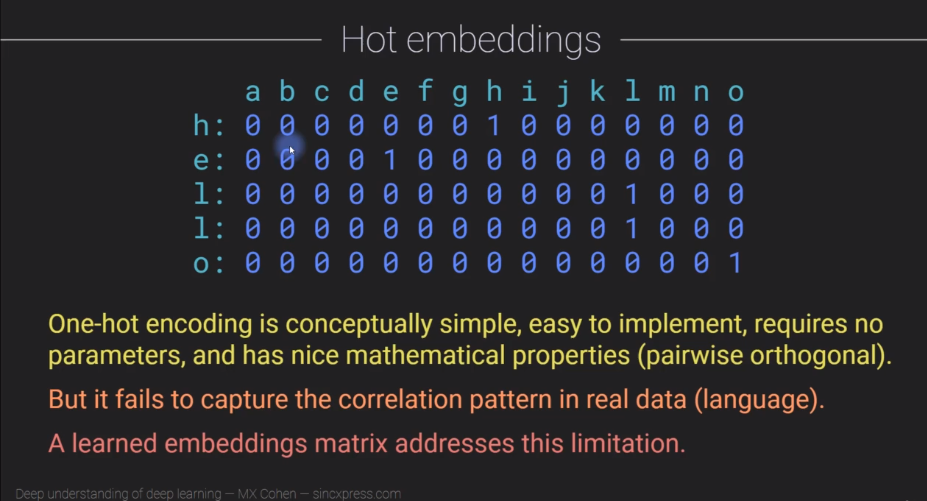

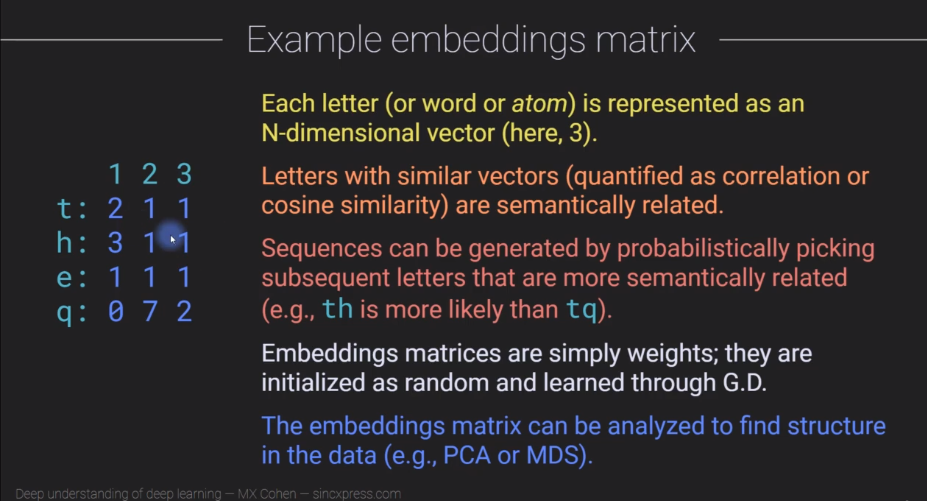

# GRU

Gate - sigmoid function

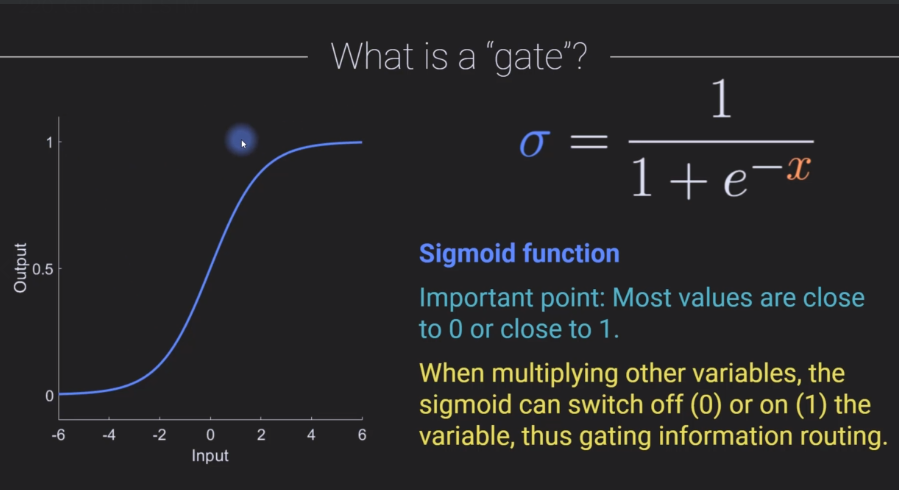

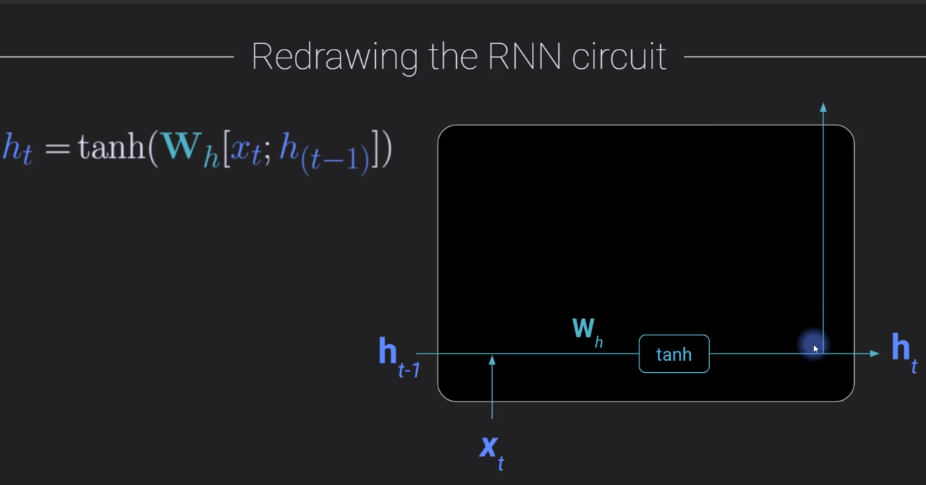

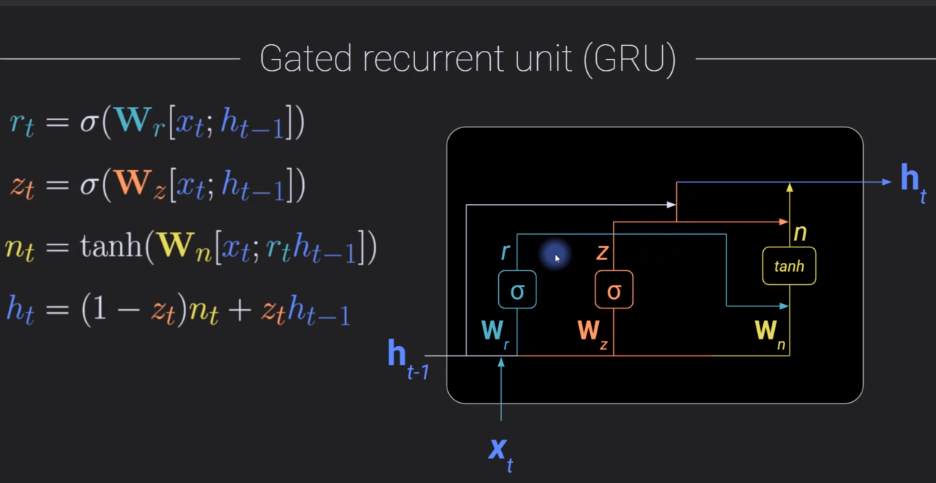

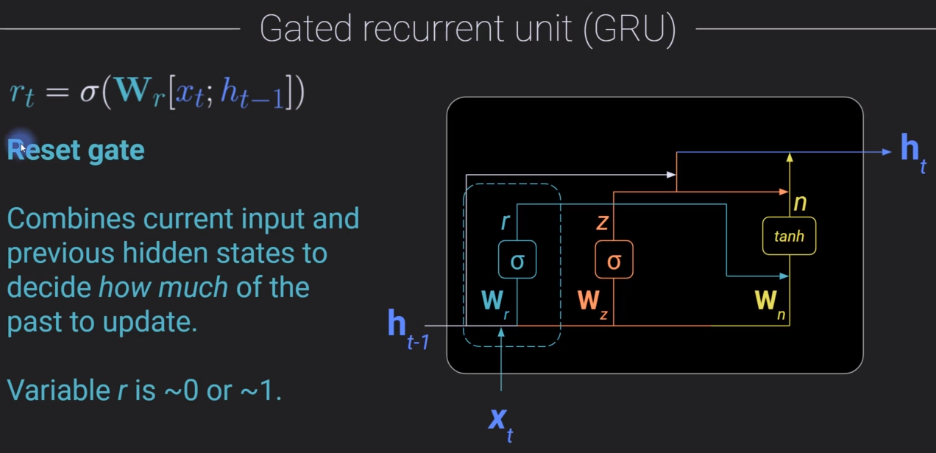

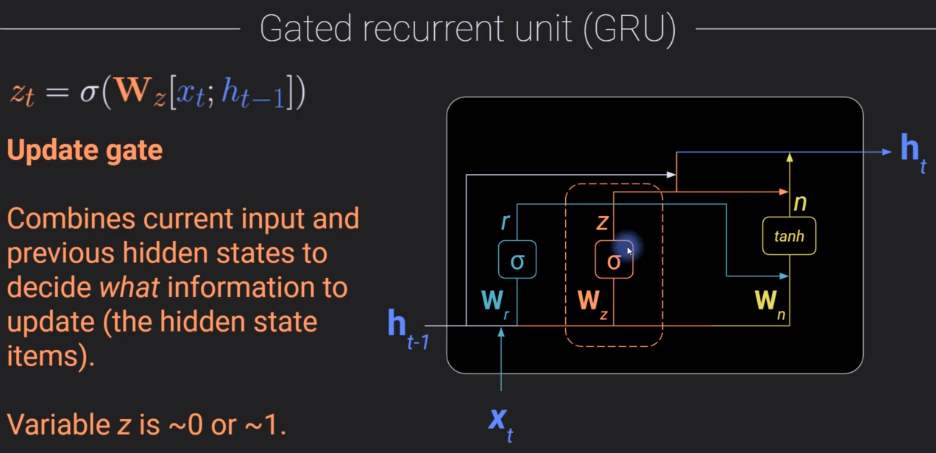

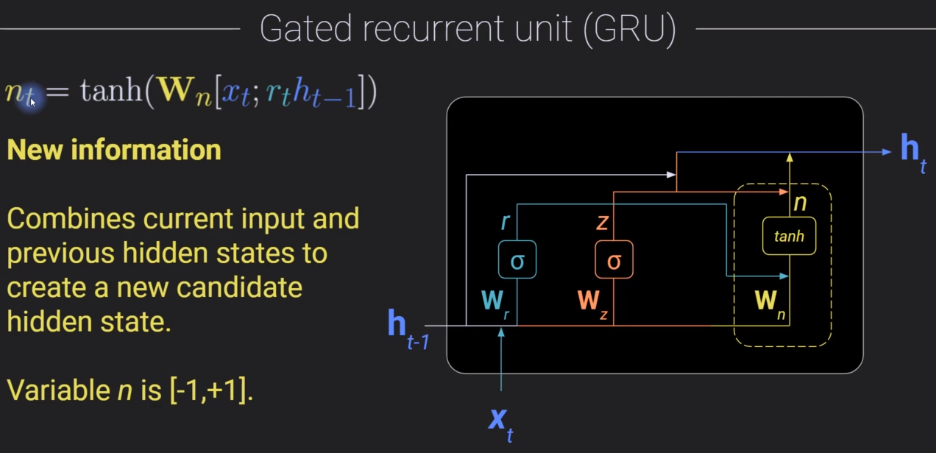

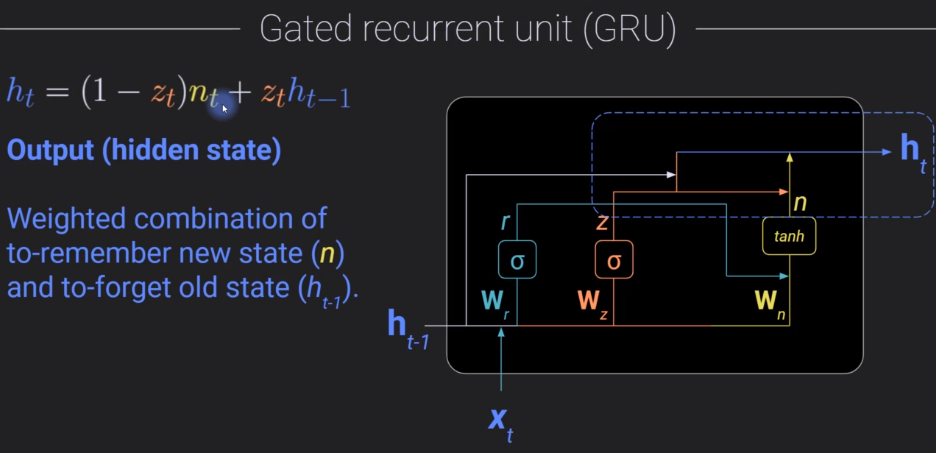

Update gate preservves balance between updating old information 
($h_{t-1}$) vs updating new information $n_t$

# LSTM

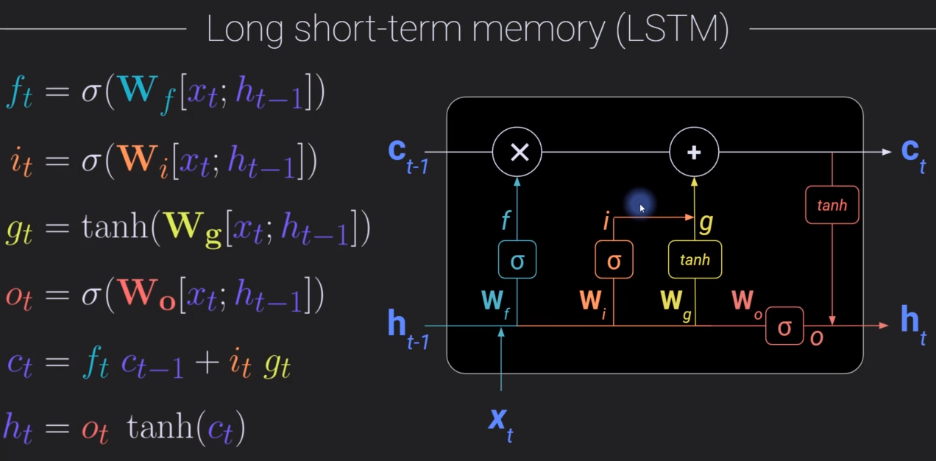

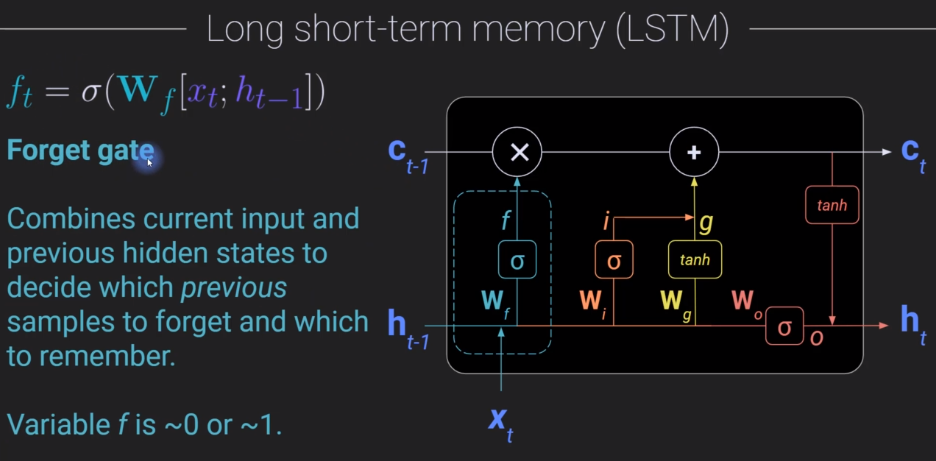

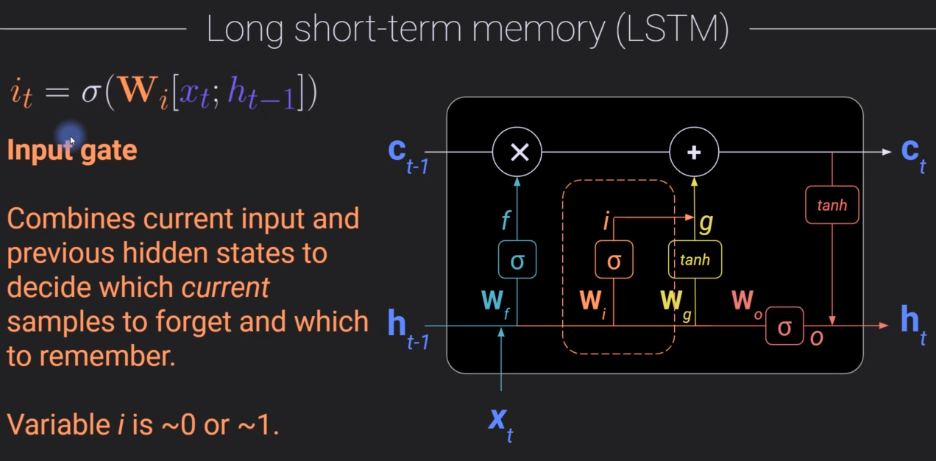

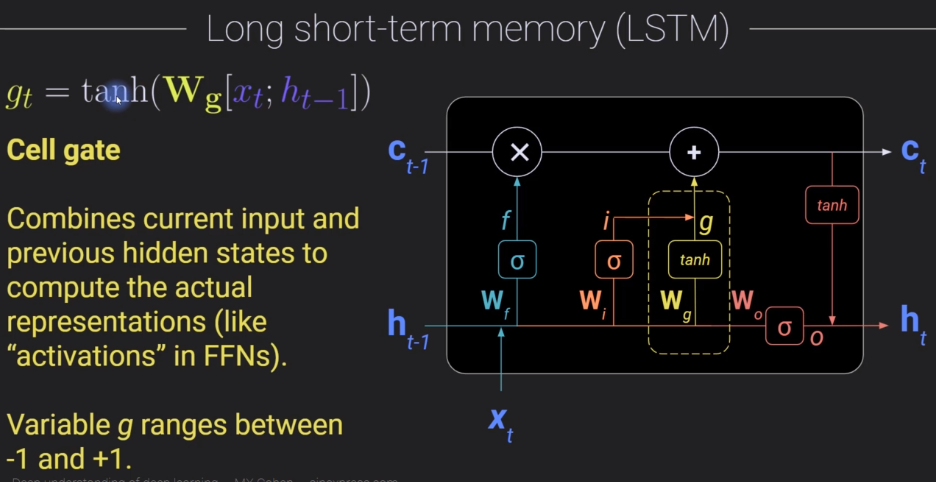

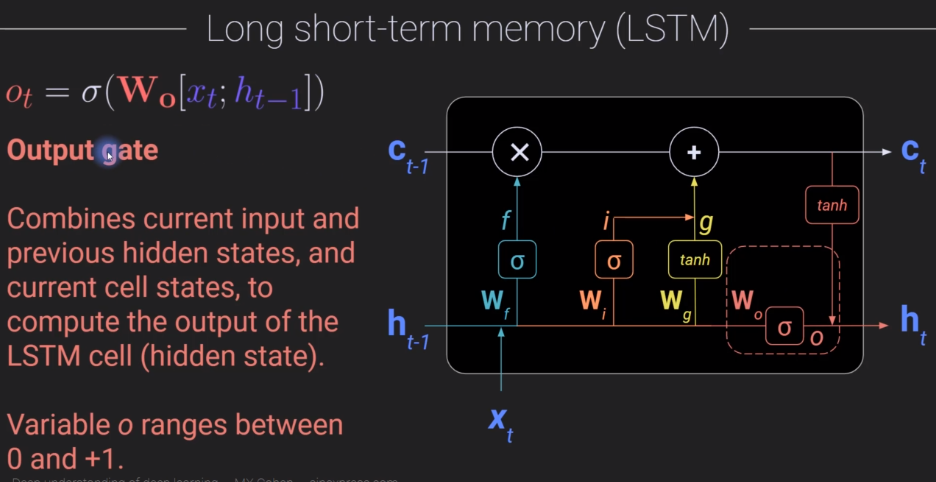

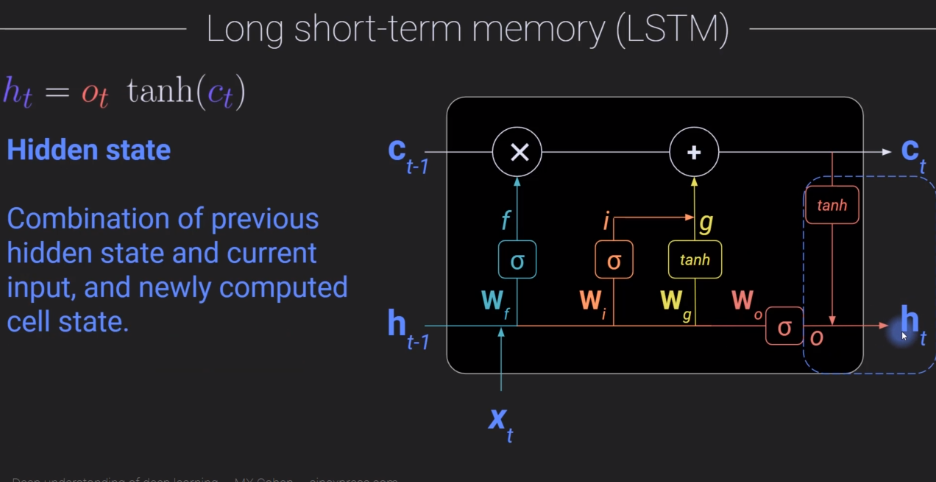

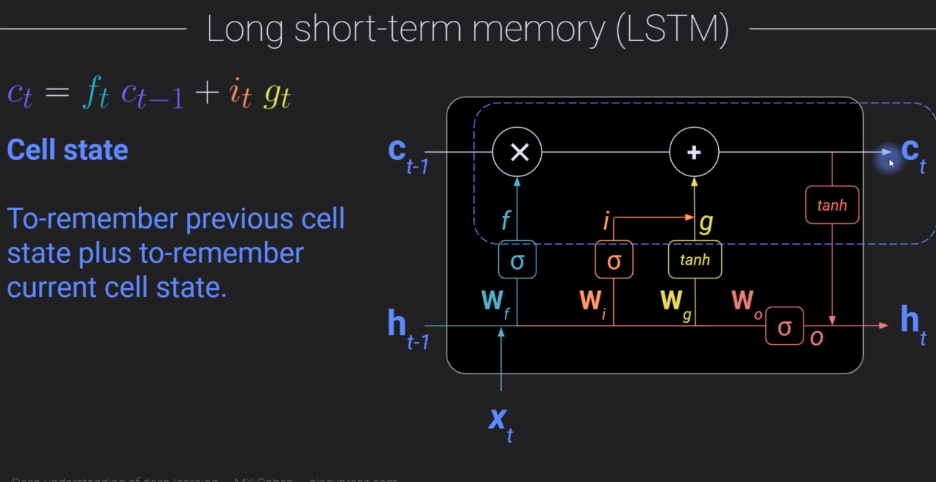

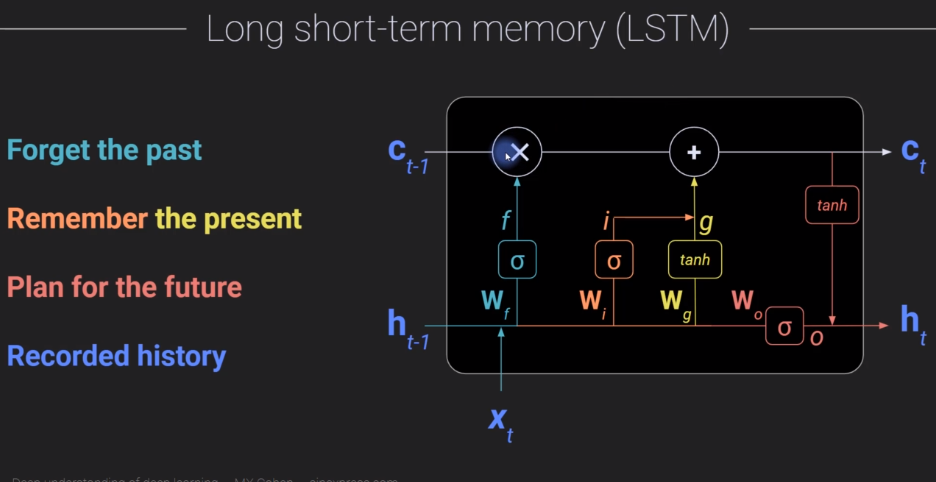

X, C, H keep changing but the 0 will be shared for all steps

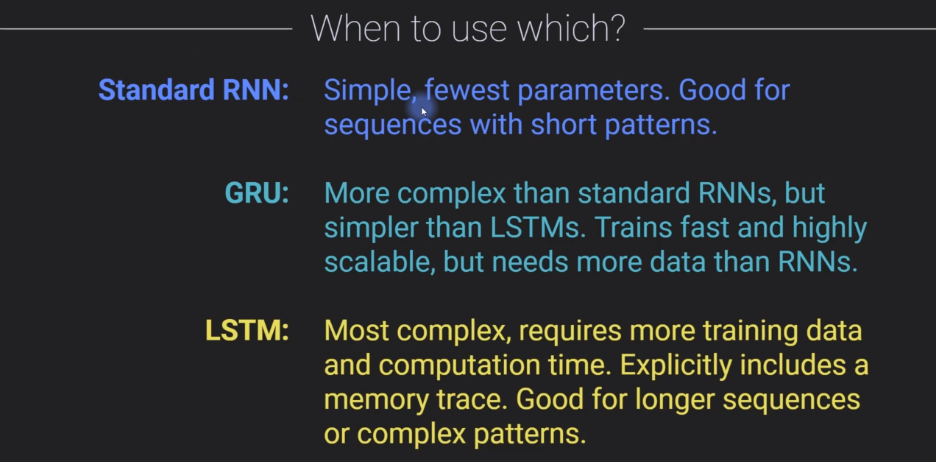

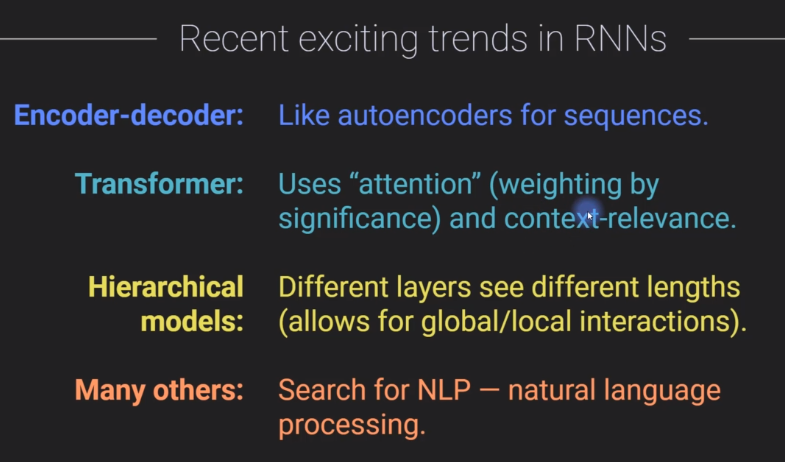

# LSTM and GRU class

In [2]:
import torch
import torch.nn as nn
import numpy as np

In [9]:
# setting layer parameters

ip_size = 9 # no. of features to extract (eg. no. of data channels)
hidden_size = 16 # number of units in hidden state
nLayers = 2 # no. of vertical stacks of hidden layers (note: only the final layer gives an output)


# creating LSTM instance
lstm = nn.LSTM(ip_size, hidden_size, nLayers)
lstm

LSTM(9, 16, num_layers=2)

In [10]:
#LSTM parameters

seq_length = 5
batchsize = 2

# creating  new data
X = torch.randn(seq_length,batchsize,ip_size)

# creating a hidden layer
H = torch.zeros(nLayers, batchsize, hidden_size)
C = torch.zeros(nLayers, batchsize, hidden_size)

hidden_ip = (H, C)

# passing through LSTM
y, h = lstm(X, hidden_ip) # have to provide tuple as input
print(X.shape)
print(h[0].shape)
print(h[1].shape)
print(y.shape)

torch.Size([5, 2, 9])
torch.Size([2, 2, 16])
torch.Size([2, 2, 16])
torch.Size([5, 2, 16])


In [11]:
# checking the learned parameters and their sizes
for p in lstm.named_parameters():
    if 'weight' in p[0]:
        print(f'{p[0]} has size {list(p[1].shape)}')

weight_ih_l0 has size [64, 9]
weight_hh_l0 has size [64, 16]
weight_ih_l1 has size [64, 16]
weight_hh_l1 has size [64, 16]


The weight matrix size is 64X9 instead of 16X9 i.e. (4\*16)X9 as the 4 weight matrices used in LSTM are concatenated into one

### Creating a model class

In [19]:
class LSTMNet(nn.Module):
    def __init__(self, ip_size, nHidden, nLayers):
        super().__init__()
        
        # store parameters
        self.ip_size = ip_size
        self.nHidden = nHidden
        self.nLayers = nLayers
        
        # RNN layer
        self.lstm = nn.LSTM(ip_size, nHidden, nLayers)
        
        # linear layer for op
        self.op = nn.Linear(nHidden, 1)
        
    def forward(self, x):
        print(f'Input:{list(x.shape)}')
        
        # run through RNN
        y, hidden = self.lstm(x)
        print(f'LSTM-out:{list(y.shape)}')
        print(f'LSTM-hidden:{list(hidden[0].shape)}')
        print(f'LSTM-cell:{list(hidden[1].shape)}')
        
        # run RNN op through op layer
        o = self.op(y)
        print(f'Output:{list(o.shape)}')
        
        return o, hidden

In [20]:
# creating instance of LSTM net

net = LSTMNet(ip_size, hidden_size, nLayers)
print(net, ' ')

for p in net.named_parameters():
    print(f'{p[0]:>20} has size {list(p[1].shape)}')

LSTMNet(
  (lstm): LSTM(9, 16, num_layers=2)
  (op): Linear(in_features=16, out_features=1, bias=True)
)  
   lstm.weight_ih_l0 has size [64, 9]
   lstm.weight_hh_l0 has size [64, 16]
     lstm.bias_ih_l0 has size [64]
     lstm.bias_hh_l0 has size [64]
   lstm.weight_ih_l1 has size [64, 16]
   lstm.weight_hh_l1 has size [64, 16]
     lstm.bias_ih_l1 has size [64]
     lstm.bias_hh_l1 has size [64]
           op.weight has size [1, 16]
             op.bias has size [1]


In [21]:
# testing model with some data

X = torch.rand(seq_length, batchsize, ip_size)
y = torch.rand(seq_length, batchsize, 1)
yH, h = net(X)

lossfn = nn.MSELoss()
lossfn(yH, y)

Input:[5, 2, 9]
LSTM-out:[5, 2, 16]
LSTM-hidden:[2, 2, 16]
LSTM-cell:[2, 2, 16]
Output:[5, 2, 1]


tensor(0.6214, grad_fn=<MseLossBackward0>)

### GRU

In [22]:
gru = nn.GRU(ip_size, hidden_size, nLayers)
gru

GRU(9, 16, num_layers=2)

In [25]:
X = torch.rand(seq_length, batchsize, ip_size)
H = torch.rand(nLayers, batchsize, hidden_size)

y,h = gru(X,H) # no cell states in GRU
print(X.shape)
print(h.shape)
print(y.shape)

torch.Size([5, 2, 9])
torch.Size([2, 2, 16])
torch.Size([5, 2, 16])


In [26]:
for p in gru.named_parameters():
    if 'weight' in p[0]:
        print(f'{p[0]} has size {list(p[1].shape)}')

weight_ih_l0 has size [48, 9]
weight_hh_l0 has size [48, 16]
weight_ih_l1 has size [48, 16]
weight_hh_l1 has size [48, 16]


 Like LSTM, GRU has 3 weight matrices, hence its shape is (16*3)X9

# Lorem Ipsum

Implementing LSTM and embeddings matrix in Pytorch, and translating text to numbers and back

In [41]:
import torch
import torch.nn as nn
import numpy as np

import sys
import warnings; warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent molestie sapien auctor eleifend egestas. Fusce at purus sodales, viverra nunc quis, consequat augue. Vestibulum eget tempus lorem, et blandit dui. Suspendisse ac gravida odio. Maecenas consequat tristique mi, vitae rutrum lacus pulvinar vitae. Nunc ullamcorper nulla eu velit vehicula, vitae facilisis erat dignissim. Proin consectetur nec lacus ac pellentesque. Nulla purus ligula, commodo id tellus id, efficitur varius massa. Phasellus et volutpat felis, gravida imperdiet justo. Cras metus velit, aliquet et tristique sit amet, elementum ultrices dui. Nullam condimentum quis orci quis pretium. Mauris tincidunt ante nec ex tristique, a commodo quam eleifend. Nam convallis ultrices magna fringilla porta. Phasellus non lobortis nisi. Donec nec lectus ligula. Maecenas id purus at lectus auctor finibus sit amet et enim. Vivamus nibh urna, dapibus sed porta in, sodales vitae elit. Fusce sed facilisis elit, ut porta massa. Vivamus blandit congue erat eget rutrum. Nullam mollis, eros et laoreet euismod, nunc mi condimentum eros, mollis pretium mi orci in nibh. Pellentesque rhoncus justo et pretium tempor. Ut gravida egestas quam, sit amet sagittis tortor scelerisque in. Vestibulum sed odio urna. Donec semper quis erat quis laoreet. Ut malesuada volutpat sem ac luctus. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Praesent sed bibendum sapien, id imperdiet elit. Vestibulum erat lorem, finibus eu enim non, posuere tempus velit. Vestibulum a massa id orci interdum malesuada eu vel tellus. Proin tempus viverra scelerisque. Nullam suscipit laoreet nisl, id consequat sem porttitor et. Integer congue urna lacus, ac feugiat arcu tincidunt eget. Aliquam erat volutpat. Vivamus accumsan semper gravida. Mauris porta magna vitae semper hendrerit. Vestibulum urna nunc, faucibus sit amet auctor sed, scelerisque nec est. Nulla ut sagittis urna. Proin fermentum turpis non iaculis tincidunt. Maecenas scelerisque rutrum hendrerit. Sed fermentum vehicula molestie. Sed nec rutrum nisi. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Cras malesuada, magna in ornare pretium, leo tellus sodales tortor, sit amet fermentum nunc odio eu enim. Quisque placerat eros ornare nulla vulputate, at efficitur sem convallis. Sed libero risus, viverra a turpis a, sollicitudin feugiat neque. Fusce vitae erat commodo, consectetur lacus vel, sollicitudin lorem. Nunc sed risus arcu. Pellentesque nec eleifend risus, a fringilla odio. Sed auctor augue a rutrum maximus. Maecenas suscipit tellus sem, vitae suscipit nisl euismod a. Phasellus elementum sodales urna, ac fringilla mi malesuada id. Suspendisse sollicitudin rhoncus dolor ut consequat. Duis tincidunt quis neque nec tincidunt. Fusce vitae sagittis nulla. Suspendisse ac varius mauris. Maecenas dapibus posuere velit, nec pellentesque quam sagittis a. Nunc aliquet justo vitae justo pharetra consectetur. Nam porttitor at nisl sit amet ullamcorper. Sed rutrum, nulla ac porttitor pulvinar, nisi leo hendrerit magna, non luctus nibh risus eget est. Quisque pulvinar rutrum vehicula. Ut tempor placerat sollicitudin. Etiam pharetra sit amet nulla at fringilla. Pellentesque feugiat odio ligula, ac ullamcorper leo vulputate a. Vestibulum placerat interdum arcu, sit amet ullamcorper ipsum finibus sed. Aliquam erat volutpat. Nam tincidunt, augue eu eleifend dictum, tellus sem blandit sem, et pulvinar ex purus sed leo. Nullam ultricies tincidunt sem, imperdiet condimentum ex porttitor at. Nunc id lacus sit amet nibh elementum dignissim. Nam facilisis tincidunt tincidunt. Suspendisse in mauris vel dui imperdiet facilisis. Aenean eu neque tortor. Cras sit amet mi nibh. Mauris sit amet feugiat nulla. Nam ac leo ipsum. Vestibulum id enim sit amet est pharetra consectetur. Vestibulum et lacus sed ipsum placerat blandit vitae quis nisl. Curabitur lacus est, euismod non accumsan sed, accumsan nec lectus. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Maecenas ultrices eros in erat molestie interdum. Nunc et tellus orci. Maecenas et magna ornare mauris sodales malesuada. Duis iaculis ipsum non laoreet porta. Aenean vitae purus tempor, porttitor arcu id, bibendum enim. Aliquam faucibus congue eros, eget feugiat risus venenatis a. Duis malesuada, sem eu mattis placerat, velit lectus varius tellus, eget placerat nibh quam non turpis. Donec auctor pellentesque odio, nec pulvinar nisi fermentum eget. Mauris eget eleifend metus. Mauris venenatis arcu semper erat facilisis, malesuada viverra tortor imperdiet. Nunc ut quam sit amet ex varius euismod. Mauris eleifend lectus venenatis risus mattis consequat. Nulla a eros non erat egestas consequat nec volutpat neque. In diam nulla, mollis ut semper nec, vulputate luctus odio. Morbi ac elementum quam, ut vestibulum sem. Ut tincidunt sapien ac fermentum ullamcorper. Cras convallis tortor quis malesuada dignissim. Suspendisse rutrum cursus diam, in consequat nisi vulputate sit amet. Nunc euismod consectetur libero eu pulvinar. Ut finibus scelerisque lectus vel auctor. Vivamus congue non sem et tincidunt. Vestibulum vehicula erat sed nisi mattis aliquet. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Etiam pulvinar tortor enim, vel blandit mauris sodales quis. Ut bibendum dui non posuere pellentesque. Phasellus metus diam, blandit accumsan porta a, pharetra nec nulla. Nam pulvinar, lacus et ornare luctus, magna orci tincidunt lorem, porttitor tincidunt enim mi a ligula. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Etiam quis mi porta, mattis velit vel, rhoncus nisi. Etiam lobortis placerat lacus.'.lower()
# generated at https://www.lipsum.com/

print(text)

lorem ipsum dolor sit amet, consectetur adipiscing elit. praesent molestie sapien auctor eleifend egestas. fusce at purus sodales, viverra nunc quis, consequat augue. vestibulum eget tempus lorem, et blandit dui. suspendisse ac gravida odio. maecenas consequat tristique mi, vitae rutrum lacus pulvinar vitae. nunc ullamcorper nulla eu velit vehicula, vitae facilisis erat dignissim. proin consectetur nec lacus ac pellentesque. nulla purus ligula, commodo id tellus id, efficitur varius massa. phasellus et volutpat felis, gravida imperdiet justo. cras metus velit, aliquet et tristique sit amet, elementum ultrices dui. nullam condimentum quis orci quis pretium. mauris tincidunt ante nec ex tristique, a commodo quam eleifend. nam convallis ultrices magna fringilla porta. phasellus non lobortis nisi. donec nec lectus ligula. maecenas id purus at lectus auctor finibus sit amet et enim. vivamus nibh urna, dapibus sed porta in, sodales vitae elit. fusce sed facilisis elit, ut porta massa. vivamu

### Preprocessing text data

In [31]:
# get all unique characters
unique_char = set(text)
unique_char

{' ',
 ',',
 '.',
 ';',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'x'}

In [33]:
# look-up tables to convert indices to chars and vice versa

num2let = dict(enumerate(unique_char))
let2num = { l:i for i,l in num2let.items()}

num2let[2], let2num['e']

('b', 1)

tensor([[ 0],
        [24],
        [23],
        ...,
        [ 5],
        [ 9],
        [ 3]], device='cuda:0')


Text(0, 0.5, 'Character label')

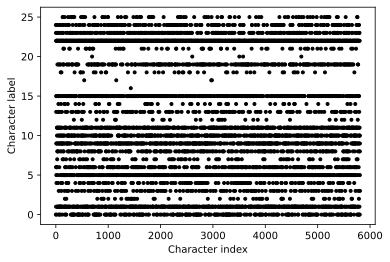

In [36]:
# convert text from char to number

data = torch.zeros((len(text),1), dtype=torch.int64, device=device)

for i, ch in enumerate(text):
    data[i] = let2num[ch]
    
print(data)
plt.plot(data.cpu().numpy(), 'k.')
plt.xlabel('Character index')
plt.ylabel('Character label')

### Creating LSTM model class

In [50]:
class LSTMNet(nn.Module):
    def __init__(self, ip_size, op_size, hidden_size, nLayers):
        super().__init__()
        
        # embedding layer
        self.embedding = nn.Embedding(ip_size, ip_size)
        
        # LSTM layer
        self.lstm = nn.LSTM(ip_size, hidden_size, nLayers)
        
        # op layer
        self.op = nn.Linear(hidden_size, op_size)
        
    def forward(self, x, h):
        # embedding layer
        embedding = self.embedding(x)
        
        # lstm
        y, h = self.lstm(embedding, h)
        
        # output
        y = self.op(y)
        
        return y, (h[0].detach(), h[1].detach())

In [51]:
# meta-parameters
hidden_size = 512   # size of hidden state
seq_length   = 80    # length of sequence
nLayers  = 3     # number of stacked hidden layers
epochs      = 10    # training epochs

In [52]:
# model instance

lstm = LSTMNet(len(unique_char), len(unique_char), hidden_size, nLayers).to(device)

# lossfn and optim
lossfn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(lstm.parameters(),lr=.001)

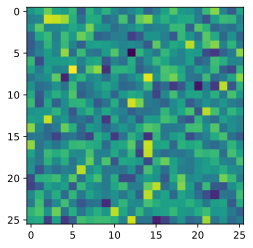

In [48]:
# visualizing randimly initialized embedding matrix

I = next(lstm.embedding.named_parameters())
plt.imshow(I[1].cpu().detach())

### Training  model

In [53]:
losses = np.zeros(epochs)

for i in range(epochs):
    
    # initializing loss and hidden state for this epoch
    txtloss = 0
    hidden_state = None
    
    # looping through entire text char-wise
    for loc in range(0, len(text)-seq_length):
        
        # input is n text chars, and target is n chars shifted by 1
        x = data[loc : loc + seq_length]
        y = data[loc+1 : loc + seq_length + 1]
        
        # forward pass
        op, hidden_state = lstm(x, hidden_state)
        
        # loss
        loss = lossfn(torch.squeeze(op), torch.squeeze(y))
        txtloss += loss.item()
        
        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    
    losses[i] = txtloss/loc
    
    sys.stdout.write('\r' + f'finished epoch {i+1}/{epochs}')

finished epoch 10/10

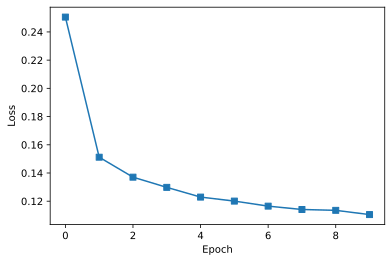

In [54]:
# check out the losses
plt.plot(losses,'s-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [56]:
# how many characters to generate?
lorem_length = 200

# random character from data to begin
x = torch.tensor(let2num['x']).view(1,1).to(device)
lorem = num2let[x.item()]

# initialize the hidden state
hidden_state = None


# generate the text!
for i in range(lorem_length):

    # push a letter though the LSTM
    output, hidden_state = lstm(x,hidden_state)

    # get the maximum output and replace input data
    index = torch.argmax(output).item()
    x[0][0] = index

    # append that output to the text
    lorem += num2let[index]


## what's it say?!?!?!
lorem

'x per conubia nostra, per inceptos himenaeos. etiam quis mi porta, mattis velit vel, rhoncus nisi. etiam lobortis placerat lacus et malesuada fames ac turpis egestas. etiam quis mi porta, mattis velit '

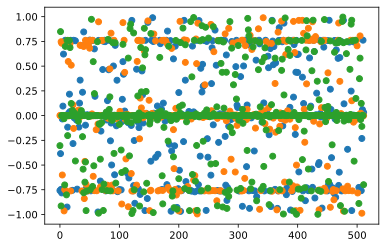

In [58]:
# plot hidden states
for i in range(nLayers):
    plt.plot(hidden_state[0][i,0,:].cpu().numpy(),'o');

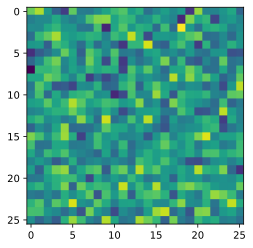

In [59]:
# visualize the learned embeddings matrix
I = next(lstm.embedding.named_parameters())
I = I[1].cpu().detach().numpy()
plt.imshow(I);

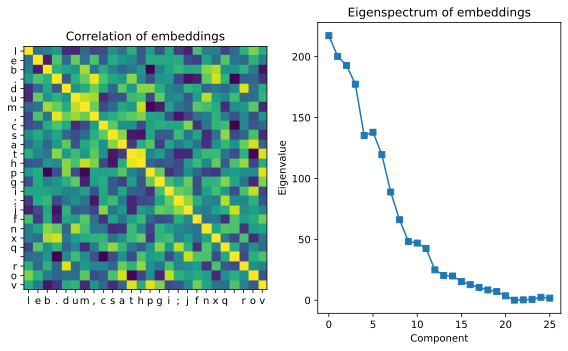

In [60]:
# FYI, lots can be done with this matrix, e.g., PCA...
d,V = np.linalg.eig(I@I.T)

fig,axs = plt.subplots(1,2,figsize=(8,5))
axs[0].imshow(np.corrcoef(I),vmin=-.5,vmax=.5)
axs[0].set_title('Correlation of embeddings')
axs[0].set_xticks(range(len(let2num.keys())))
axs[0].set_xticklabels(let2num.keys())
axs[0].set_yticks(range(len(let2num.keys())))
axs[0].set_yticklabels(let2num.keys())

axs[1].plot(d,'s-')
axs[1].set_xlabel('Component')
axs[1].set_ylabel('Eigenvalue')
axs[1].set_title('Eigenspectrum of embeddings')

plt.tight_layout()
plt.show()